In [1]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd
from aldiscore.prediction import utils
from aldiscore import ROOT, RSTATE

from aldiscore.prediction.predictor import DifficultyPredictor


In [2]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, drop_df, label_df = utils.load_features(
    data_dir,
    exclude_features=["is_dna", "num_seqs", "seq_length", "frst"],
)
# feat_df.columns = clean_feat_names

print(feat_df.shape)
print(drop_df.shape)
print(label_df.shape)

Dropping 11431 NaN rows...
(0, 721)
(11431, 93)
(0, 1)


In [7]:
# # TEST PERFORMANCE ON WITHHELD DATA
# excluded = "bali3"
# excl_idxs = feat_df.query(f"source == '{excluded}'").index.copy()
# excl_feats = feat_df.loc[excl_idxs].copy()
# excl_labels = label_df.loc[excl_idxs].copy()
# feat_df = feat_df.drop(excl_idxs, axis=0)
# label_df = label_df.drop(excl_idxs, axis=0)
# print(feat_df.shape)
# print(drop_df.shape)
# print(label_df.shape)

In [4]:
# print("max num seqs", drop_df["num_seqs"].max())
# print("max seq len", drop_df["max:seq_length"].max())

In [3]:
from sklearn.model_selection import train_test_split

train_idxs, test_idxs = train_test_split(
    feat_df.index.to_list(), test_size=0.2, random_state=RSTATE
)
test_idxs, valid_idxs = train_test_split(test_idxs, test_size=0.5, random_state=RSTATE)
print(len(train_idxs), len(test_idxs), len(valid_idxs))
#
X_train = feat_df.loc[train_idxs]
X_test = feat_df.loc[test_idxs]
X_valid = feat_df.loc[valid_idxs]
y_train = label_df.loc[train_idxs].iloc[:, 0]
y_test = label_df.loc[test_idxs].iloc[:, 0]
y_valid = label_df.loc[valid_idxs].iloc[:, 0]

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
param_df = pd.read_parquet(ROOT / "optuna" / "trial_03.parquet")
param_df.head(5)
params = dict(param_df.drop("score", axis=1).iloc[0])
params["n_estimators"] = 1500

In [4]:
param_df

NameError: name 'param_df' is not defined

In [5]:
import lightgbm as lgb

for key, val in params.items():
    if isinstance(params[key], float) and (float(int(val)) == val):
        params[key] = int(val)
# Train the model
model = lgb.LGBMRegressor(**params)
model = model.fit(X_train, y_train)

In [ ]:
# predictor = DifficultyPredictor(model.booster_)
# predictor.save("v0.3.txt")

model = DifficultyPredictor("latest")
score = model.predict(str(ROOT / "demo" / "data" / "protein.0.fasta"), drop_gaps=True)
score

np.float64(0.6213040540362462)

In [39]:
if isinstance(model, DifficultyPredictor):
    model = model.model
y_pred = model.predict(feat_df.loc[valid_idxs])
y_true = label_df.loc[valid_idxs].to_numpy().ravel()
# mask = y_true > 0.1
# y_pred = y_pred[mask]
# y_true = y_true[mask]

# y_pred = model.predict(dnaf_feats)
# y_true = dnaf_labels.to_numpy().ravel()

In [40]:
eps = 1e-2
perf_df = utils.compute_metrics(model, X_test, y_test, eps)
print(perf_df)
print()
print(np.sort(np.abs(y_pred - y_true) / (y_true + eps))[::-1][:20])

     RMSE RMSE_CV     MAE    MAPE MAPE_P50    CORR
0  0.0436  0.2868  0.0256  0.2489   0.1437  0.9720

[6.57819623 4.21029201 4.04985337 3.29878672 2.25325951 2.05257966
 1.91762098 1.89748052 1.87257072 1.72494271 1.60100894 1.57442143
 1.47684465 1.35423809 1.34334809 1.32993145 1.31848437 1.28446297
 1.27889904 1.24976446]


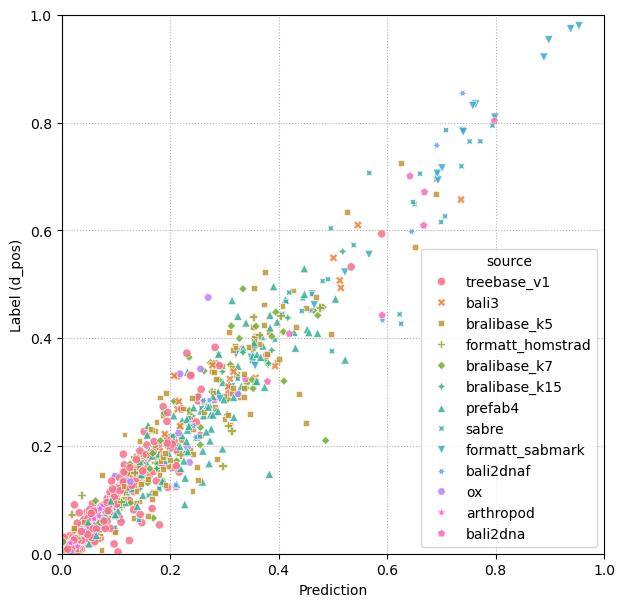

In [26]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[valid_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 7))
sn.scatterplot(x=y_pred, y=y_true, alpha=0.85, style=sources, hue=sources)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

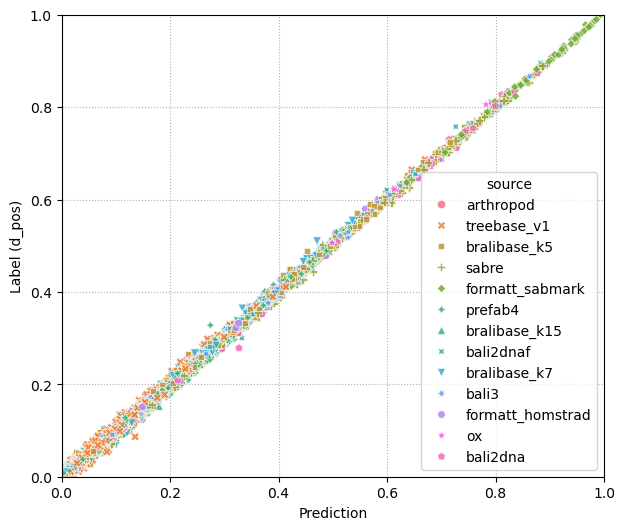

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[train_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 6))
sn.scatterplot(
    x=model.predict(feat_df.loc[train_idxs]),
    y=label_df.loc[train_idxs].to_numpy().ravel(),
    alpha=0.85,
    style=sources,
    hue=sources,
)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

In [ ]:
test = feat_df.copy()
test["label"] = label_df["mean"]
corr = test.corr().loc["label"]
corr = corr.iloc[corr.abs().argsort()[::-1]]
corr[:20]

label                1.000000
p70.tc_base_p50     -0.885261
p70.tc_base_mean    -0.883455
p70.tc_base_min     -0.882662
mean.tc_base_p50    -0.882356
p60.tc_base_p50     -0.882130
mean.tc_base_mean   -0.881187
p60.tc_base_mean    -0.881015
mean.tc_base_max    -0.880528
p70.tc_base_max     -0.879801
mean.tc_base_min    -0.879684
p60.tc_base_max     -0.879450
p60.tc_base_min     -0.879217
p50.tc_base_p50     -0.874936
p50.tc_base_mean    -0.874196
p50.tc_base_max     -0.874180
p80.tc_base_p50     -0.872961
p50.tc_base_min     -0.872034
p80.tc_base_min     -0.871198
p80.tc_base_mean    -0.870324
Name: label, dtype: float64

In [ ]:
imps = model.feature_importance("gain")
imps


# # else:
# imps = model.feature_importances_
# imp_df = pd.DataFrame(dict(feature=feat_df.columns, importance=imps))
# imp_df = imp_df.sort_values("importance", ignore_index=True, ascending=False)
# imp_df[:10]
# imp_df[imp_df.feature.str.contains("mer")].iloc[:10]
# imp_df
# # np.save(ROOT / "top_feats.npy", imp_df.feature[:50].to_numpy())

array([1.76741837e+01, 9.05170046e-01, 3.90400951e+00, 7.21766775e-01,
       2.85076636e+00, 3.86365895e-01, 1.89703203e+00, 1.17691104e+00,
       1.95932649e+00, 1.74592337e+00, 2.98750874e+00, 2.84242599e+00,
       1.49776667e+00, 1.32534720e+00, 1.22621959e+00, 4.88946049e-01,
       6.22372606e+00, 1.84989891e+00, 1.80195625e+00, 2.95652074e-01,
       1.34479599e+00, 2.59816165e-01, 1.43629467e+00, 3.49476777e-01,
       8.17355616e-01, 5.52849846e-01, 1.58785373e+00, 2.51189344e-01,
       2.35340762e+00, 3.08336830e-01, 1.30970047e+00, 3.51171937e-01,
       1.34123452e+00, 5.01085110e-01, 1.65315017e+00, 3.31618284e-01,
       2.43797917e+00, 7.65375974e-01, 1.74084122e+00, 8.52230917e-01,
       1.07656568e+00, 1.44448557e+00, 1.73289180e+00, 9.55300525e-01,
       2.34454238e+00, 2.07488100e+00, 2.50125267e+00, 1.26879574e+00,
       1.68873220e+00, 7.03280715e-01, 1.83535895e+00, 3.55606598e-01,
       1.68818849e+00, 6.90179662e-01, 1.22929783e+00, 4.05984957e-01,
      

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

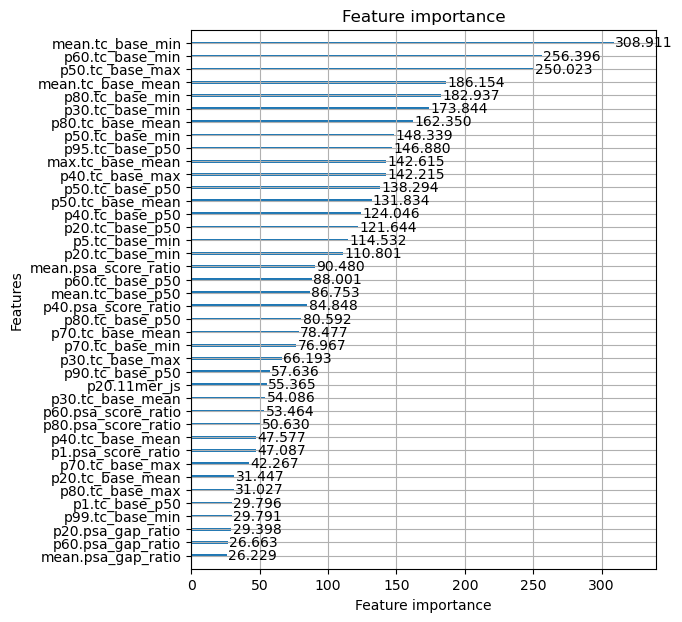

In [16]:
lgb.plot_importance(model, figsize=(6, 7), importance_type="gain", max_num_features=40)
# else:
#     pass
# sn.barplot(x=feat, y=importance[sort_idxs], hue=is_tc)
# ax = plt.gca()
# _ = ax.set_xticklabels([])
# _ = ax.legend(title="Consistency-based")
# _ = ax.set_ylabel("Feature importance")
# _ = ax.set_xlabel("Features")
# print(top_feats[:30])

In [ ]:
label_df.sort_values("mean", ascending=False).tail(40)
test_df = label_df.copy().reset_index()
test_df["iszero"] = test_df["mean"] == 0
test_df.groupby(["source"]).mean(numeric_only=True)

,mean,iszero
source,,
arthropod,0.039345,0.000000
bali2dna,0.395273,0.000000
bali2dnaf,0.397796,0.000000
bali3,0.280096,0.000000
bralibase_k15,0.116012,0.262425
bralibase_k5,0.135846,0.290229
bralibase_k7,0.128771,0.285414
formatt_homstrad,0.150750,0.033742
formatt_sabmark,0.695928,0.000000
